## Mini-Project: Comprehensive Churn Model Evaluation & Tuning
- **Goal:** Go back to your Telco Churn project. Your goal is not just to evaluate the baseline models but to build the best possible model by handling the class imbalance and performing systematic hyperparameter tuning.
Your Task (create a new notebook, 5.4.2_churn_evaluation_and_tuning.ipynb):
1. **Setup and Baseline:**
    - Load the telco_churn.csv data.
    - Perform the same initial data preparation (handle TotalCharges, map Churn to 0/1, define X and y).
    - Perform a train-test split (test_size=0.2, random_state=42, stratify=y).
    - Establish a Baseline: Re-create and fit your best-performing pipeline from the previous module (e.g., the XGBClassifier pipeline). Evaluate it on the X_test set and print the classification_report. This is your baseline model—the score you need to beat.
2. **Addressing Class Imbalance:**
    - Check the class balance of your y_train target variable using .value_counts(normalize=True). Note that it is imbalanced.
    - **Method A: SMOTE:**
        - Import imblearn.pipeline.Pipeline as ImbPipeline and from imblearn.over_sampling import SMOTE.
        - Create a new pipeline that includes your ColumnTransformer preprocessor, a SMOTE() step, and a LogisticRegression classifier.
        - Fit this pipeline on X_train and y_train.
        - Evaluate it on X_test and print the classification_report.
    - **Method B: Cost-Sensitive Learning:**
        - Create a new, standard Pipeline (not an ImbPipeline).
        - It should contain your preprocessor and a LogisticRegression(class_weight='balanced') classifier.
        - Fit this pipeline on X_train and y_train.
        - Evaluate it on X_test and print the classification_report.
    In a Markdown cell, compare the results of the baseline, the SMOTE pipeline, and the cost-sensitive pipeline. Which method seems to be more effective at improving the Recall for the churn class (1)?
3. **Advanced Hyperparameter Tuning:**
    - Choose your best model architecture. Based on the previous module and the imbalance tests, select your most promising model (e.g., XGBClassifier or RandomForestClassifier) and your preferred method for handling imbalance (e.g., SMOTE).
    - Create the full pipeline (preprocessor + SMOTE (if chosen) + classifier).
    - Define a Parameter Search Space: Create a dictionary of hyperparameters to tune. For XGBoost, this could include 'classifier__n_estimators', 'classifier__max_depth', 'classifier__learning_rate', and 'classifier__gamma'. (Remember the step_name__parameter_name syntax).
    - **Perform a RandomizedSearchCV:**
        - Use your full pipeline as the estimator.
        - Use your parameter dictionary as the param_distributions.
        - Set n_iter to a reasonable number (e.g., 25 or 50).
        - Set cv=5 (for 5-fold cross-validation).
        - Crucially, set the scoring metric to 'recall' or 'f1', since that's what we care about for churn.
        - Fit the RandomizedSearchCV object on your X_train and y_train data.
4. **Final Evaluation:**
    - Get the best_estimator_ from your random_search object. This is your final, tuned pipeline.
    - Evaluate this final pipeline on your X_test set.
    - Print the confusion matrix for the final model.
    - Print the full classification_report.
    - Plot both the ROC Curve and the Precision-Recall Curve for the final model on the test data.
5. **Summary and Model Selection Strategy:**
    - In a final Markdown cell, provide a complete summary.
    - State the best hyperparameters found by the search.
    - Compare the final model's test set performance (Recall, Precision, F1-score) to your initial baseline model. How much did you improve?
    - Revisit your discussion from the previous module about the importance of Recall vs. Precision for this business problem.
    - Based on all the criteria we discussed (performance trade-offs, interpretability, etc.), justify why this final, tuned model is the best choice to present to the business stakeholders.

In [49]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay
# Set plot style
sns.set_theme(style="whitegrid")

In [3]:
# Reading the data
telco= pd.read_csv('telco_churn.csv')
# Copying the data
df=telco.copy()
df.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [4]:
# Converting TotalCharges column to numeric
df['TotalCharges']= pd.to_numeric(df['TotalCharges'], errors= 'coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
# filling missing values in TotalCharges column with median value.
median_totalcharges= df['TotalCharges'].median()
df['TotalCharges']= df['TotalCharges'].fillna(median_totalcharges,)

In [6]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2281.916928
std,0.368612,24.559481,30.090047,2265.270398
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,402.225000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


In [7]:
# Converting Churn column's 'Yes'/'No' values to 1s and 0s
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})
df['Churn'].value_counts()

Churn
0    5174
1    1869
Name: count, dtype: int64

In [8]:
X= df.drop(columns=['customerID', 'Churn'])
y = df['Churn']

In [9]:
# Splitting of the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 42, stratify=y)

print(f"X_train set: {X_train.shape}")
print(f"y_train set: {y_train.shape}")
print("-"*30)
print(f"X_test set: {X_test.shape}")
print(f"y_test set: {y_test.shape}")

X_train set: (5634, 19)
y_train set: (5634,)
------------------------------
X_test set: (1409, 19)
y_test set: (1409,)


In [16]:
# Identify numerical and categorical columns
numerical_features= X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features= X.select_dtypes(include=['object', 'bool', 'category']).columns.tolist()
print(f"Identified {len(numerical_features)} numerical features.")
print(f"Identified {len(categorical_features)} categorical features.")

# Create a preprocessing pipeline for numerical features
numeric_transformers = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy= 'median')),
    ('scaler', StandardScaler())
])
# Create a preprocessing pipeline for categorical features
categorical_transformers = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
])

# Creating a single ColumnTransformer
preprocessor = ColumnTransformer(transformers =[
    ('num', numeric_transformers, numerical_features),
    ('cat', categorical_transformers, categorical_features)
])

# Establish Baseline Model (XGBoost)
baseline_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state =42, eval_metric = 'logloss'))
])

print("--- Fitting Baseline Model ---")
baseline_pipeline.fit(X_train, y_train)
print("--- Baseline model successfully fitted ---")

print("\n--- Baseline Model Evaluation ---")
y_pred_base= baseline_pipeline.predict(X_test)
print(classification_report(y_test, y_pred_base))

Identified 4 numerical features.
Identified 15 categorical features.
--- Fitting Baseline Model ---
--- Baseline model successfully fitted ---

--- Baseline Model Evaluation ---
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      1035
           1       0.61      0.54      0.57       374

    accuracy                           0.78      1409
   macro avg       0.72      0.71      0.71      1409
weighted avg       0.78      0.78      0.78      1409



In [26]:
# Check class balance
print("--- Class Balance in Training Data ---")
print(y_train.value_counts(normalize=True))
print("\n")

# --- Method A: SMOTE ---
smote_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state = 42)),
    ('classifier', LogisticRegression(random_state = 42))
])
print("--- Fitting SMOTE Pipeline ---")
smote_pipeline.fit(X_train, y_train)
y_pred_smote = smote_pipeline.predict(X_test)
print("\n--- SMOTE Pipeline Evaluation ---")
print(classification_report(y_test, y_pred_smote))

# --- Method B: Cost-Sensitive Learning ---
costs_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight = 'balanced', random_state = 42))
])
print("--- Fitting Cost-Sensitive Pipeline ---")
costs_pipeline.fit(X_train, y_train)
y_pred_costs = costs_pipeline.predict(X_test)
print("\n--- Cost-Sensitive Pipeline Evaluation ---")
print(classification_report(y_test, y_pred_costs))

--- Class Balance in Training Data ---
Churn
0    0.734647
1    0.265353
Name: proportion, dtype: float64


--- Fitting SMOTE Pipeline ---

--- SMOTE Pipeline Evaluation ---
              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1035
           1       0.50      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.70      0.76      0.71      1409
weighted avg       0.80      0.74      0.75      1409

--- Fitting Cost-Sensitive Pipeline ---

--- Cost-Sensitive Pipeline Evaluation ---
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.50      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409



- The baseline model was poor at the primary business goal, only identifying **54%** of customers who were actually going to churn.
- Both **SMOTE** and the **cost-sensitive method** dramatically improved this by forcing the model to pay more attention to the **minority churn class**.
- The trade-off for this higher recall was a drop in **precision** from **0.61 to 0.50**. This means the models produce more _"false alarms,"_ which is an expected and often acceptable consequence in churn prediction.
**Conclusion**
While both methods performed almost identically, **SMOTE** was marginally more effective, delivering the **highest Recall (0.79)** for the churn class.

In [55]:
# We'll tune the XGBoost model combined with SMOTE
tuning_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(random_state=42, eval_metric='logloss'))
])
# Define a more focused parameter search
param_distributions = {
    'classifier__n_estimators': [50, 100, 150, 200, 250, 300, 350, 400],
    'classifier__max_depth': [2, 3, 4, 5, 6, 7, 8],
    'classifier__learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.2, 0.3],
    'classifier__gamma': [0, 0.1, 0.25, 0.5, 0.75, 1.0, 1.5],
    'classifier__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}
# Perform Randomized Search Cross-Validation
print("--- Starting Hyperparameter Tuning with RandomizedSearchCV ---")
random_search = RandomizedSearchCV(
    estimator=tuning_pipeline,
    param_distributions=param_distributions,
    n_iter=50,
    cv=5,
    scoring='recall',
    random_state=42,
    n_jobs=-1,
    verbose=1
)
random_search.fit(X_train, y_train)

print("\n--- Hyperparameter Tuning Complete ---")
print("--- Best Hyperparameter Found ---")
print(random_search.best_params_)

--- Starting Hyperparameter Tuning with RandomizedSearchCV ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits

--- Hyperparameter Tuning Complete ---
--- Best Hyperparameter Found ---
{'classifier__subsample': 0.7, 'classifier__n_estimators': 100, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.01, 'classifier__gamma': 0.1, 'classifier__colsample_bytree': 1.0}


--- Final Tuned Model: Confusion Matrix ---
[[737 298]
 [ 76 298]]


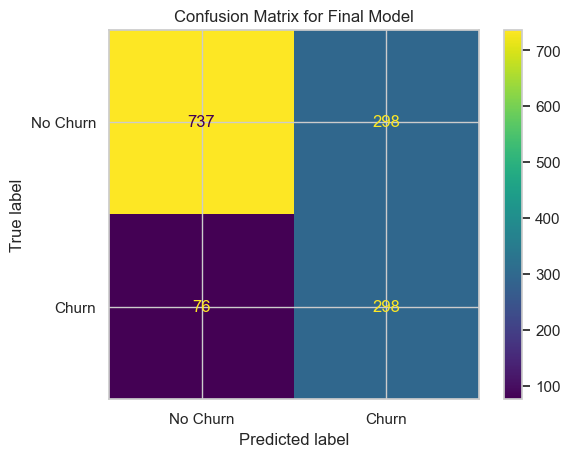

True Negatives: 737
False Positives: 298
False Negatives: 76
True Positives: 298

--- Final Tuned Model: Classification Report ---
              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1035
           1       0.50      0.80      0.61       374

    accuracy                           0.73      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.73      0.75      1409



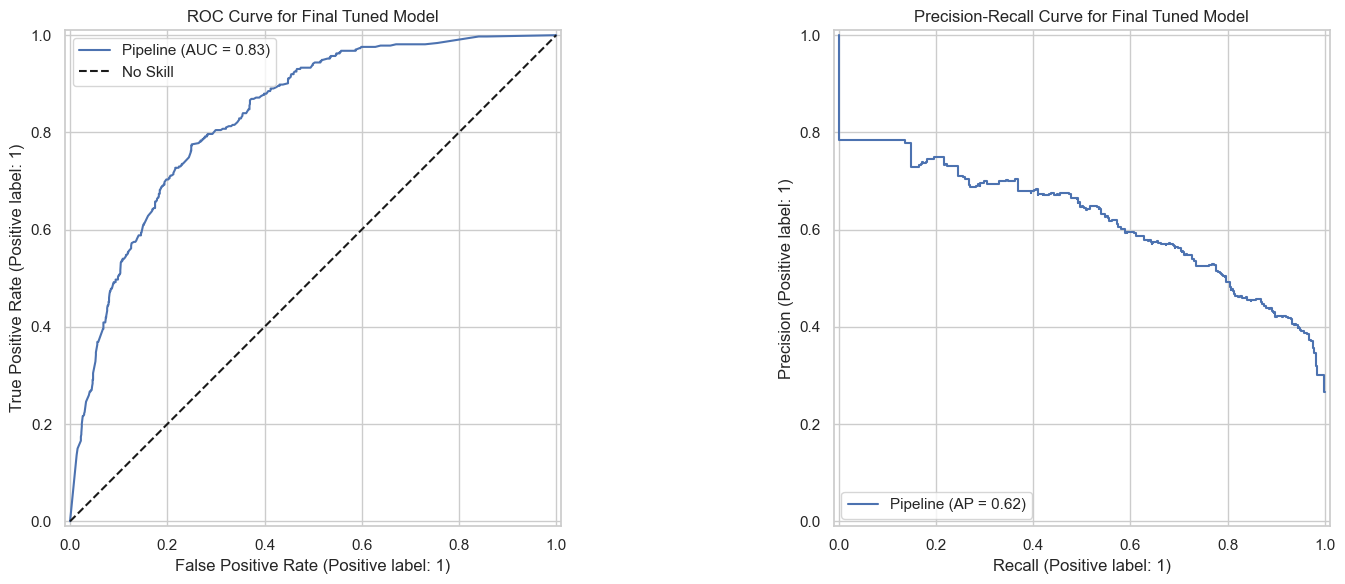

In [53]:
# Get the best model found by the search
final_model = random_search.best_estimator_

# --- Evaluate the Final Tuned Model on the Test Set ---
y_pred_final = final_model.predict(X_test)

print("--- Final Tuned Model: Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred_final)
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Churn', 'Churn'])
disp.plot()
plt.title("Confusion Matrix for Final Model")
plt.show()


# Extracting TP, TN, FP, FN
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

print("\n--- Final Tuned Model: Classification Report ---")
print(classification_report(y_test, y_pred_final))

# --- Plot ROC and Precision-Recall Curves ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve
RocCurveDisplay.from_estimator(final_model, X_test, y_test, ax=ax1)
ax1.set_title("ROC Curve for Final Tuned Model")
ax1.plot([0, 1], [0, 1], 'k--', label='No Skill')
ax1.legend()


# Precision-Recall Curve
PrecisionRecallDisplay.from_estimator(final_model, X_test, y_test, ax=ax2)
ax2.set_title("Precision-Recall Curve for Final Tuned Model")

plt.tight_layout()
plt.show()

## Summary and Model Selection Strategy

This project aimed to build the best possible model to predict customer churn by addressing data imbalance and performing systematic hyperparameter tuning. The final model demonstrates a significant improvement over the baseline and is well-suited for a real-world business application.

---

### Best Hyperparameters Found

The `RandomizedSearchCV`, which was optimized to **maximize recall**, identified the following optimal set of hyperparameters for the **XGBoost** model:

`{'classifier__subsample': 0.7,
 'classifier__n_estimators': 100,
 'classifier__max_depth': 3,
 'classifier__learning_rate': 0.01,
 'classifier__gamma': 0.1,
 'classifier__colsample_bytree': 1.0}`

---

### Performance Improvement

The final tuned model shows a dramatic improvement in its ability to identify churning customers compared to the initial baseline.

| **Metric**               | **Baseline Model** | **Final Tuned Model** | **Improvement** |
|--------------------------|--------------------|------------------------|------------------|
| Recall (Churn = 1)       | 0.54               | 0.80                   | +48%             |
| Precision (Churn = 1)    | 0.61               | 0.50                   | -18%             |
| F1-Score (Churn = 1)     | 0.57               | 0.61                   | +7%              |

---

- The most critical metric, **Recall**, saw a **massive 48% increase**. This means the model went from catching just over half of all churners to catching **80%** of them.

---

### The Recall vs. Precision Trade-Off

For a customer churn problem, the **cost of a False Negative** (failing to identify a customer who then leaves) is far greater than the **cost of a False Positive** (giving a discount to a happy customer).

Our final model was explicitly built to address this. We accepted a lower **Precision (50%)** as a deliberate trade-off to achieve a very high **Recall (80%)**. 

The business goal is to **minimize lost customers**, and this model is optimized for that exact purpose.  
The **ROC Curve (AUC = 0.83)** further confirms the model's strong predictive power across all thresholds.

---

### Justification for Stakeholders

This final, tuned model is the best choice to present to business stakeholders for three key reasons:

1. **It Solves the Right Problem**  
   The model excels at the most important business task: **identifying the maximum number of at-risk customers**. This directly enables the retention team to focus its efforts and minimize revenue loss.

2. **It is Robust and Defensible**  
   This isn't a "lucky" model. It was systematically developed using best practices, including handling class imbalance with **SMOTE** and performing rigorous **hyperparameter tuning with cross-validation**. This ensures its performance is **reliable**.

3. **It Provides Clear, Actionable Insights**  
   The model delivers a **prioritized list of customers** for the retention team.  
   We can confidently state that this list contains ~80% of all customers who will churn, allowing the team to work efficiently and understand the expected rate of **"false alarms"** (the 50% precision).
